<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_var3_RF_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
from utils.hourglass import *
from utils.dataloader import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

Loading [1/2000] pictures......


KeyboardInterrupt: ignored

In [ ]:
helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [ ]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [ ]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......


In [ ]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Iter [1/200] loss 0.4851
Iter [10/200] loss 0.3919
Iter [20/200] loss 0.3299
Iter [30/200] loss 0.2775
Iter [40/200] loss 0.2264
Iter [50/200] loss 0.1907
Iter [60/200] loss 0.1593
Iter [70/200] loss 0.1372
Iter [80/200] loss 0.1207
Iter [90/200] loss 0.1067
Iter [100/200] loss 0.0961
Iter [110/200] loss 0.0875
Iter [120/200] loss 0.0809
Iter [130/200] loss 0.0753
Iter [140/200] loss 0.0708
Iter [150/200] loss 0.0667
Iter [160/200] loss 0.0625
Iter [170/200] loss 0.0536
Iter [180/200] loss 0.0481
Iter [190/200] loss 0.0452
Iter [200/200] loss 0.0411


Text(0.5, 1.0, 'Training Loss')

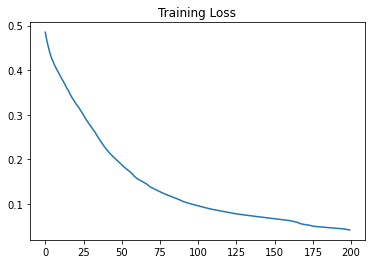

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.5f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

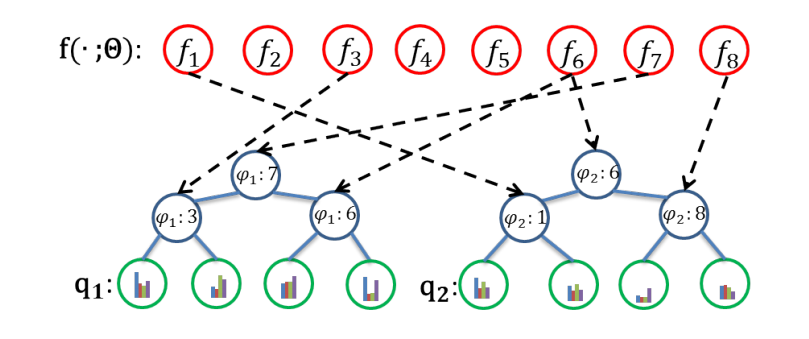

In [6]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [7]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [8]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [9]:
def phi(cnn_fc):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [10]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [11]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [12]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [13]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(pred,l)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [14]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

## 4.2 Sample Set

In [15]:
helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.3 Network

In [16]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [17]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.4 Training

In [18]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 1000

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12*256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q).reshape(B,12,256,256)
      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)

      loss_epoch += loss.item()
      if (iter+1)%20 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12*256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(num_leaf_nodes,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(num_leaf_nodes):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))





### Training using Log likelihood

############################################################################
Round 1, Using GPU
     CNN training, Iter [1/30], loss_KL: 3.854769
     -----> CNN training time: ## 2.72 mins ## 


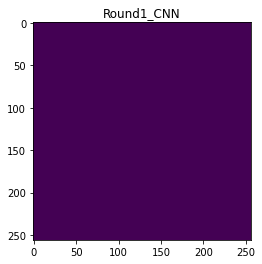

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8559
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8558
     RF training, coordinate loss: 6167.4253


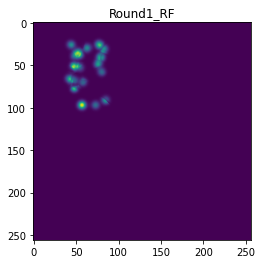

     -----> RF training time: ## 9.89 mins ## 
     -----> Training time for this round: ## 12.60 mins ## 
############################################################################
Round 2, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855054
     CNN training, Iter [50/1000], loss_KL: 3.855053
     CNN training, Iter [100/1000], loss_KL: 3.855053
     CNN training, Iter [150/1000], loss_KL: 3.855053
     CNN training, Iter [200/1000], loss_KL: 3.855053
     CNN training, Iter [250/1000], loss_KL: 3.855052
     CNN training, Iter [300/1000], loss_KL: 3.855052
     CNN training, Iter [350/1000], loss_KL: 3.855052
     CNN training, Iter [400/1000], loss_KL: 3.855051
     CNN training, Iter [450/1000], loss_KL: 3.855051
     CNN training, Iter [500/1000], loss_KL: 3.855051
     CNN training, Iter [550/1000], loss_KL: 3.855050
     CNN training, Iter [600/1000], loss_KL: 3.855050
     CNN training, Iter [650/1000], loss_KL: 3.855050
     CNN training, Iter [700/1000], loss_KL:

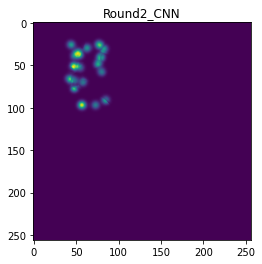

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8558
     RF training, coordinate loss: 6409.8149


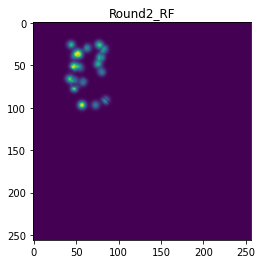

     -----> RF training time: ## 9.84 mins ## 
     -----> Training time for this round: ## 100.09 mins ## 
############################################################################
Round 3, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855048
     CNN training, Iter [50/1000], loss_KL: 3.855048
     CNN training, Iter [100/1000], loss_KL: 3.855048
     CNN training, Iter [150/1000], loss_KL: 3.855048
     CNN training, Iter [200/1000], loss_KL: 3.855047
     CNN training, Iter [250/1000], loss_KL: 3.855047
     CNN training, Iter [300/1000], loss_KL: 3.855047
     CNN training, Iter [350/1000], loss_KL: 3.855047
     CNN training, Iter [400/1000], loss_KL: 3.855046
     CNN training, Iter [450/1000], loss_KL: 3.855046
     CNN training, Iter [500/1000], loss_KL: 3.855046
     CNN training, Iter [550/1000], loss_KL: 3.855046
     CNN training, Iter [600/1000], loss_KL: 3.855045
     CNN training, Iter [650/1000], loss_KL: 3.855045
     CNN training, Iter [700/1000], loss_KL

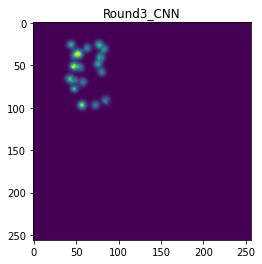

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6630.5649


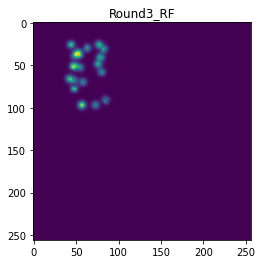

     -----> RF training time: ## 9.78 mins ## 
     -----> Training time for this round: ## 99.18 mins ## 
############################################################################
Round 4, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855044
     CNN training, Iter [50/1000], loss_KL: 3.855043
     CNN training, Iter [100/1000], loss_KL: 3.855043
     CNN training, Iter [150/1000], loss_KL: 3.855043
     CNN training, Iter [200/1000], loss_KL: 3.855043
     CNN training, Iter [250/1000], loss_KL: 3.855043
     CNN training, Iter [300/1000], loss_KL: 3.855042
     CNN training, Iter [350/1000], loss_KL: 3.855042
     CNN training, Iter [400/1000], loss_KL: 3.855042
     CNN training, Iter [450/1000], loss_KL: 3.855042
     CNN training, Iter [500/1000], loss_KL: 3.855042
     CNN training, Iter [550/1000], loss_KL: 3.855042
     CNN training, Iter [600/1000], loss_KL: 3.855041
     CNN training, Iter [650/1000], loss_KL: 3.855041
     CNN training, Iter [700/1000], loss_KL:

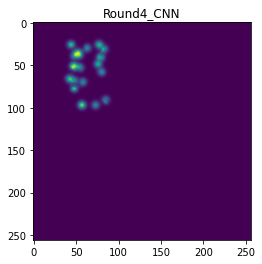

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6792.5205


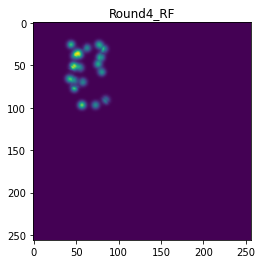

     -----> RF training time: ## 9.82 mins ## 
     -----> Training time for this round: ## 99.01 mins ## 
############################################################################
Round 5, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855040
     CNN training, Iter [50/1000], loss_KL: 3.855039
     CNN training, Iter [100/1000], loss_KL: 3.855039
     CNN training, Iter [150/1000], loss_KL: 3.855039
     CNN training, Iter [200/1000], loss_KL: 3.855039
     CNN training, Iter [250/1000], loss_KL: 3.855039
     CNN training, Iter [300/1000], loss_KL: 3.855039
     CNN training, Iter [350/1000], loss_KL: 3.855039
     CNN training, Iter [400/1000], loss_KL: 3.855038
     CNN training, Iter [450/1000], loss_KL: 3.855038
     CNN training, Iter [500/1000], loss_KL: 3.855038
     CNN training, Iter [550/1000], loss_KL: 3.855038
     CNN training, Iter [600/1000], loss_KL: 3.855038
     CNN training, Iter [650/1000], loss_KL: 3.855038
     CNN training, Iter [700/1000], loss_KL:

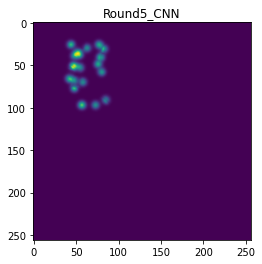

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6883.9336


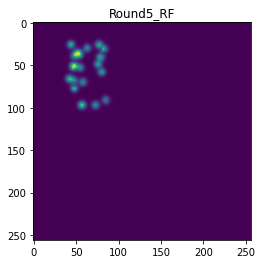

     -----> RF training time: ## 9.82 mins ## 
     -----> Training time for this round: ## 98.89 mins ## 
############################################################################
Round 6, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855037
     CNN training, Iter [50/1000], loss_KL: 3.855036
     CNN training, Iter [100/1000], loss_KL: 3.855036
     CNN training, Iter [150/1000], loss_KL: 3.855036
     CNN training, Iter [200/1000], loss_KL: 3.855036
     CNN training, Iter [250/1000], loss_KL: 3.855036
     CNN training, Iter [300/1000], loss_KL: 3.855036
     CNN training, Iter [350/1000], loss_KL: 3.855036
     CNN training, Iter [400/1000], loss_KL: 3.855036
     CNN training, Iter [450/1000], loss_KL: 3.855036
     CNN training, Iter [500/1000], loss_KL: 3.855035
     CNN training, Iter [550/1000], loss_KL: 3.855035
     CNN training, Iter [600/1000], loss_KL: 3.855035
     CNN training, Iter [650/1000], loss_KL: 3.855035
     CNN training, Iter [700/1000], loss_KL:

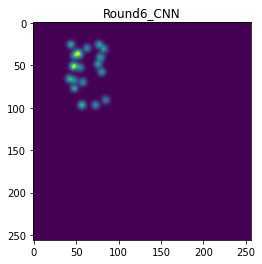

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 6935.5713


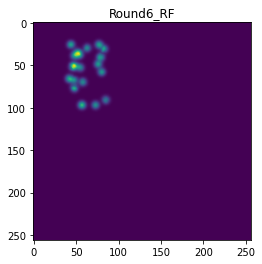

     -----> RF training time: ## 9.81 mins ## 
     -----> Training time for this round: ## 98.91 mins ## 
############################################################################
Round 7, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855034
     CNN training, Iter [50/1000], loss_KL: 3.855034
     CNN training, Iter [100/1000], loss_KL: 3.855034
     CNN training, Iter [150/1000], loss_KL: 3.855034
     CNN training, Iter [200/1000], loss_KL: 3.855034
     CNN training, Iter [250/1000], loss_KL: 3.855034
     CNN training, Iter [300/1000], loss_KL: 3.855034
     CNN training, Iter [350/1000], loss_KL: 3.855033
     CNN training, Iter [400/1000], loss_KL: 3.855033
     CNN training, Iter [450/1000], loss_KL: 3.855033
     CNN training, Iter [500/1000], loss_KL: 3.855033
     CNN training, Iter [550/1000], loss_KL: 3.855033
     CNN training, Iter [600/1000], loss_KL: 3.855033
     CNN training, Iter [650/1000], loss_KL: 3.855033
     CNN training, Iter [700/1000], loss_KL:

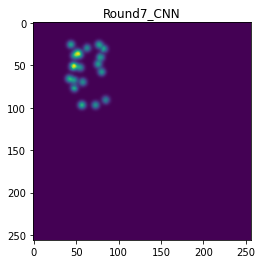

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 7027.7549


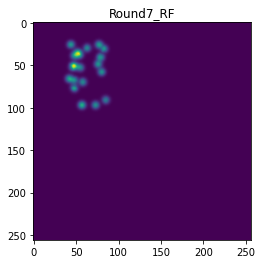

     -----> RF training time: ## 9.81 mins ## 
     -----> Training time for this round: ## 98.78 mins ## 
############################################################################
Round 8, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855032
     CNN training, Iter [50/1000], loss_KL: 3.855032
     CNN training, Iter [100/1000], loss_KL: 3.855032
     CNN training, Iter [150/1000], loss_KL: 3.855032
     CNN training, Iter [200/1000], loss_KL: 3.855032
     CNN training, Iter [250/1000], loss_KL: 3.855032
     CNN training, Iter [300/1000], loss_KL: 3.855032
     CNN training, Iter [350/1000], loss_KL: 3.855032
     CNN training, Iter [400/1000], loss_KL: 3.855031
     CNN training, Iter [450/1000], loss_KL: 3.855031
     CNN training, Iter [500/1000], loss_KL: 3.855031
     CNN training, Iter [550/1000], loss_KL: 3.855031
     CNN training, Iter [550/1000], loss_KL: 3.855031
     CNN training, Iter [600/1000], loss_KL: 3.855031
     CNN training, Iter [600/1000], loss_KL:

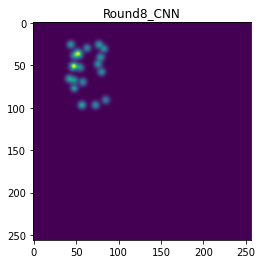

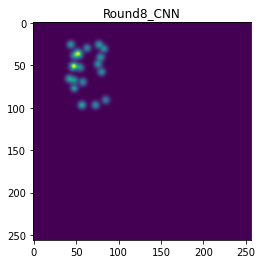

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], 

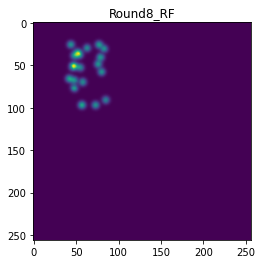

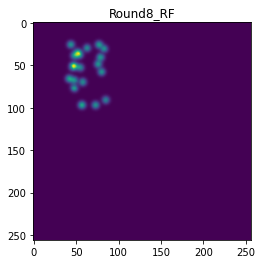

     -----> RF training time: ## 9.84 mins ## 
     -----> Training time for this round: ## 98.86 mins ## 
############################################################################
Round 9, Using GPU
     -----> RF training time: ## 9.84 mins ## 
     -----> Training time for this round: ## 98.86 mins ## 
############################################################################
Round 9, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855030
     CNN training, Iter [1/1000], loss_KL: 3.855030
     CNN training, Iter [50/1000], loss_KL: 3.855030
     CNN training, Iter [50/1000], loss_KL: 3.855030
     CNN training, Iter [100/1000], loss_KL: 3.855030
     CNN training, Iter [100/1000], loss_KL: 3.855030
     CNN training, Iter [150/1000], loss_KL: 3.855030
     CNN training, Iter [150/1000], loss_KL: 3.855030
     CNN training, Iter [200/1000], loss_KL: 3.855030
     CNN training, Iter [200/1000], loss_KL: 3.855030
     CNN training, Iter [250/1000], loss_KL: 3.855030
     C

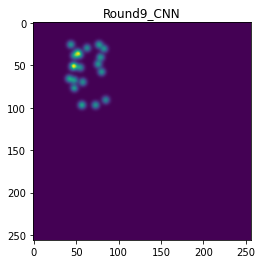

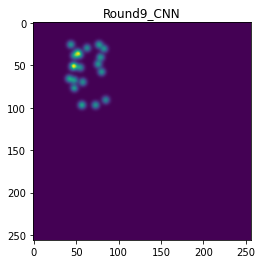

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [45/60], 

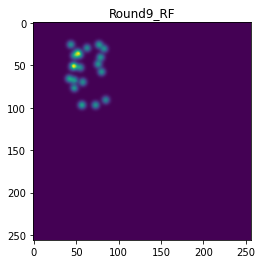

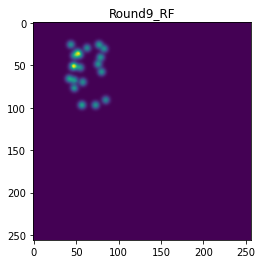

     -----> RF training time: ## 9.80 mins ## 
     -----> Training time for this round: ## 98.89 mins ## 
############################################################################
Round 10, Using GPU
     -----> RF training time: ## 9.80 mins ## 
     -----> Training time for this round: ## 98.89 mins ## 
############################################################################
Round 10, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.855029
     CNN training, Iter [1/1000], loss_KL: 3.855029
     CNN training, Iter [50/1000], loss_KL: 3.855029
     CNN training, Iter [50/1000], loss_KL: 3.855029
     CNN training, Iter [100/1000], loss_KL: 3.855029
     CNN training, Iter [100/1000], loss_KL: 3.855029
     CNN training, Iter [150/1000], loss_KL: 3.855029
     CNN training, Iter [150/1000], loss_KL: 3.855029
     CNN training, Iter [200/1000], loss_KL: 3.855029
     CNN training, Iter [200/1000], loss_KL: 3.855029
     CNN training, Iter [250/1000], loss_KL: 3.855029
    

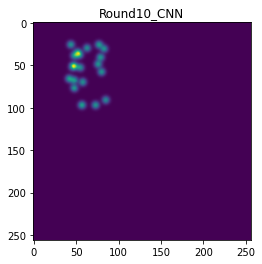

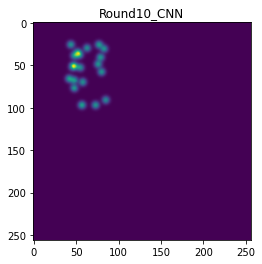

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [45/60], 

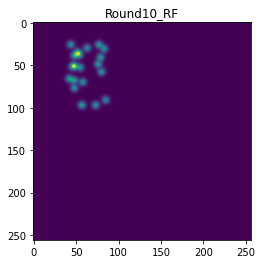

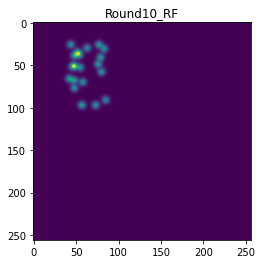

     -----> RF training time: ## 9.82 mins ## 
     -----> Training time for this round: ## 98.87 mins ## 
     -----> RF training time: ## 9.82 mins ## 
     -----> Training time for this round: ## 98.87 mins ## 
-----> Total training time: ## 15.07 hrs ## 
-----> Total training time: ## 15.07 hrs ## 


In [19]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      loss = -criterion_KL(cnn_heatmaps,label_heatmaps)

      loss_epoch += loss.item()
      if (iter+1)%50 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_KL: %.7f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  plt.imshow(cnn_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_CNN")
  plt.savefig(os.path.join("checkpoints/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0 = 0

    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          leaf_q[:,points_id,:] = update_iter(leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%15 == 0 or rf_iter == 0):
          rf_loss_CE = loss_ce(B, leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_KL: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE*224*224))


      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))


    # Sharpen Leaf_q
    # leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    # for nleaf in range(num_leaf_nodes):
    #   for npoints in range(12):
    #     leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    # leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    # leaf_q = leaf_q.reshape(num_leaf_nodes,-1)


    print("     RF training, coordinate loss: %.4f" %(loss0/10))

  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  plt.imshow(rf_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_RF")
  plt.savefig(os.path.join("checkpoints/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF.png"))
  plt.show()

  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt")))
leaf_q = torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [20]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

Heatmap loss 0.00000006, Coord loss 1112.5000
Heatmap loss 0.00000006, Coord loss 1112.5000


In [21]:
phi(outputs)[0:5,:]

tensor([[0.0622, 0.0659, 0.0617, 0.0636, 0.0650, 0.0659, 0.0633, 0.0593, 0.0618,
         0.0612, 0.0601, 0.0638, 0.0631, 0.0616, 0.0602, 0.0613, 0.0610, 0.0554,
         0.0611, 0.0611, 0.0666, 0.0689, 0.0689, 0.0620, 0.0623, 0.0606, 0.0580,
         0.0607, 0.0639, 0.0623, 0.0653, 0.0621, 0.0663, 0.0663, 0.0634, 0.0622,
         0.0583, 0.0574, 0.0605, 0.0597, 0.0637, 0.0608, 0.0670, 0.0643, 0.0639,
         0.0627, 0.0606, 0.0630],
        [0.0701, 0.0643, 0.0663, 0.0683, 0.0647, 0.0728, 0.0657, 0.0568, 0.0590,
         0.0569, 0.0635, 0.0592, 0.0610, 0.0564, 0.0552, 0.0599, 0.0642, 0.0574,
         0.0642, 0.0597, 0.0663, 0.0656, 0.0651, 0.0559, 0.0673, 0.0646, 0.0588,
         0.0583, 0.0656, 0.0595, 0.0633, 0.0641, 0.0610, 0.0651, 0.0624, 0.0607,
         0.0599, 0.0612, 0.0590, 0.0613, 0.0660, 0.0607, 0.0619, 0.0650, 0.0637,
         0.0651, 0.0645, 0.0626],
        [0.0579, 0.0647, 0.0547, 0.0637, 0.0648, 0.0676, 0.0677, 0.0560, 0.0580,
         0.0604, 0.0657, 0.0634, 0.0653, 

tensor([[0.0622, 0.0659, 0.0617, 0.0636, 0.0650, 0.0659, 0.0633, 0.0593, 0.0618,
         0.0612, 0.0601, 0.0638, 0.0631, 0.0616, 0.0602, 0.0613, 0.0610, 0.0554,
         0.0611, 0.0611, 0.0666, 0.0689, 0.0689, 0.0620, 0.0623, 0.0606, 0.0580,
         0.0607, 0.0639, 0.0623, 0.0653, 0.0621, 0.0663, 0.0663, 0.0634, 0.0622,
         0.0583, 0.0574, 0.0605, 0.0597, 0.0637, 0.0608, 0.0670, 0.0643, 0.0639,
         0.0627, 0.0606, 0.0630],
        [0.0701, 0.0643, 0.0663, 0.0683, 0.0647, 0.0728, 0.0657, 0.0568, 0.0590,
         0.0569, 0.0635, 0.0592, 0.0610, 0.0564, 0.0552, 0.0599, 0.0642, 0.0574,
         0.0642, 0.0597, 0.0663, 0.0656, 0.0651, 0.0559, 0.0673, 0.0646, 0.0588,
         0.0583, 0.0656, 0.0595, 0.0633, 0.0641, 0.0610, 0.0651, 0.0624, 0.0607,
         0.0599, 0.0612, 0.0590, 0.0613, 0.0660, 0.0607, 0.0619, 0.0650, 0.0637,
         0.0651, 0.0645, 0.0626],
        [0.0579, 0.0647, 0.0547, 0.0637, 0.0648, 0.0676, 0.0677, 0.0560, 0.0580,
         0.0604, 0.0657, 0.0634, 0.0653, 

In [ ]:
for ith in range(8):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)

(0.0, 256.0)

(0.0, 256.0)

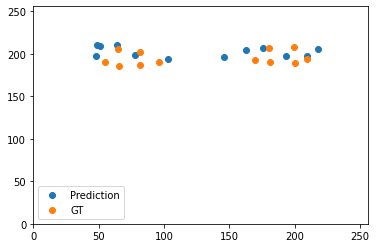

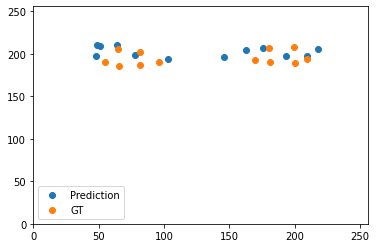

In [23]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

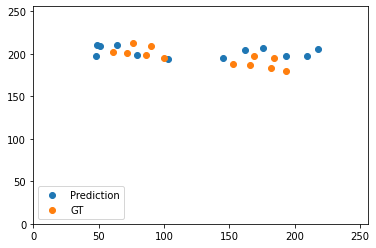

(0.0, 256.0)

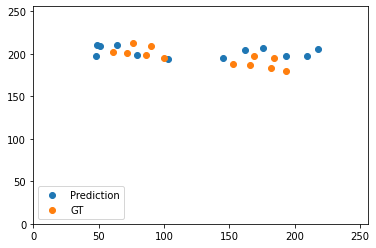

In [24]:
ith = 1

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

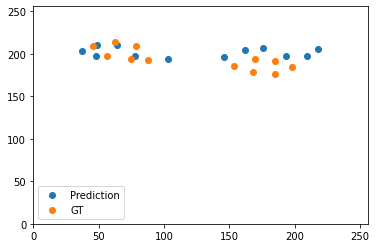

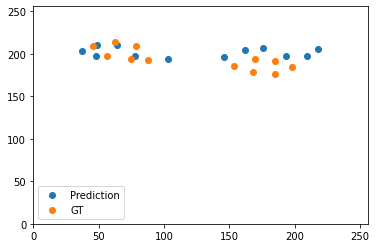

In [25]:
ith = 2

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

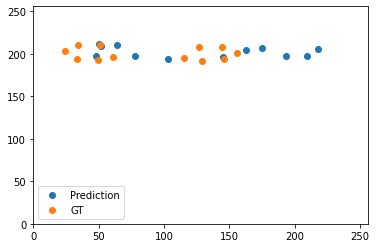

(0.0, 256.0)

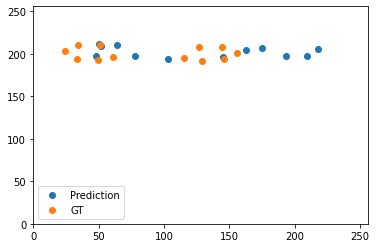

In [26]:
ith = 3

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

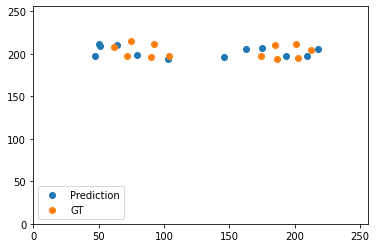

(0.0, 256.0)

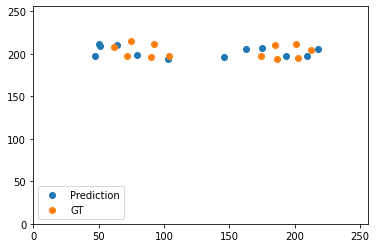

In [27]:
ith = 4

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

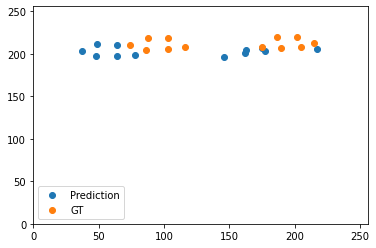

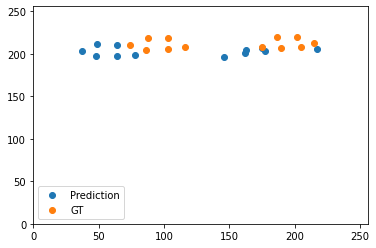

In [28]:
ith = 5

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

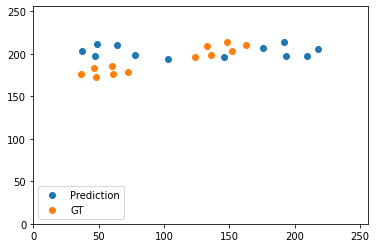

(0.0, 256.0)

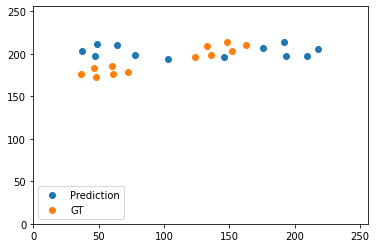

In [29]:
ith = 6

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

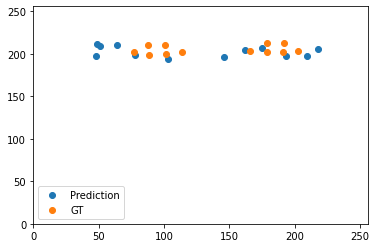

(0.0, 256.0)

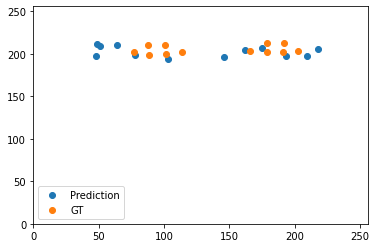

In [30]:
ith = 7

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

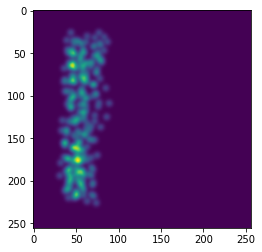

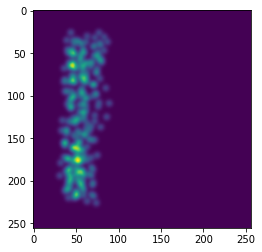

In [31]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps_all[ith,:,:])

In [ ]:
# one point
plt.imshow(plot_heatmaps[ith,0,:,:])

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[0,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[1,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[2,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[3,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[4,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[5,0,:,:].detach().cpu())

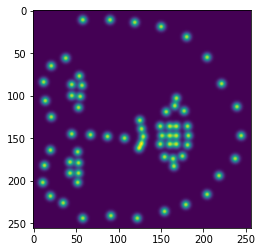

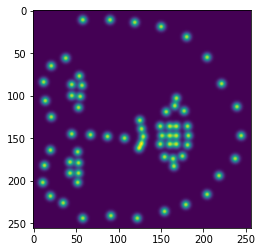

In [39]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

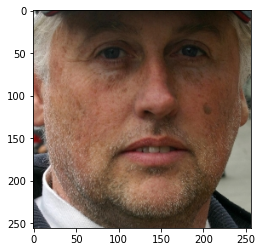

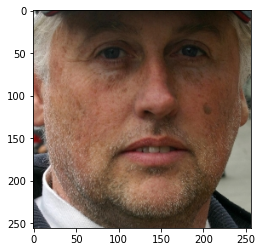

In [40]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())